
Test ukko model using LONGITUDONAL FEATIRES. 

Create a time-dependent survival dataset that combines log-logistic survival times with sinusoidal features.  
OPtions:

- [x] amplitude modulation
- [ ] frequency modulation 


  ## Amplitude modulation

This approach creates an interpretable relationship between survival times and feature patterns, where:

- Longer survival times result in higher amplitude in the first feature
- The temporal patterns in the features could be used to predict survival
- The censoring mechanism affects both the survival times and the feature patterns

SurvivalSineWaveDataset:

- Use generate_survival_data_LL() for survival times and censoring
- Keep both dynamic (sinusoidal) and static features from the survival data
- Use normalized observed times for amplitude modulation of first feature
- Use static features to modulate amplitudes of other features

plot_survival_features to show:
- First feature (amplitude modulated by survival time)
- Other dynamic features (modulated by static features)
- Original static features from generate_survival_data_LL
- Added example usage and visualization:

In [33]:
# Set environment variable to handle OpenMP runtime conflict
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Also set this for the current session
if os.name == 'nt':  # Windows
    try:
        import ctypes
        ctypes.CDLL('mkl_rt.dll')
    except:
        pass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Import required libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Import ukko functions
from ukko.survival import generate_survival_data_LL, plot_KM

class SurvivalSineWaveDataset(Dataset):
    def __init__(self, n_samples, n_features, sequence_length, 
                 shape=5, scale=10.0, censoring=0.3,
                 base_freq=0.1, noise_level=0.1, seed=42):
        """
        Creates survival dataset with sinusoidal time-dependent features.
        The true survival time modulates the amplitude of the first feature.
        Uses generate_survival_data_LL for survival times generation.
        
        Args:
            n_samples: Number of samples
            n_features: Number of features for sinusoidal patterns (actual will be n_features + original features)
            sequence_length: Length of time series
            shape: Shape parameter for log-logistic distribution
            scale: Scale parameter for log-logistic distribution
            censoring: Censoring rate
            base_freq: Base frequency of sine waves
            noise_level: Standard deviation of Gaussian noise
        """
        #np.random.seed(seed)
        #torch.manual_seed(seed)
        
        self.sequence_length = sequence_length
        self.n_features = n_features
        self.true_coefficients = np.random.uniform(0.5, 2.0, n_features) #placeholder for true coefficients
        
        # Generate survival data using ukko function
        survival_data, true_coefficients = generate_survival_data_LL(
            n_samples=n_samples,
            n_features=n_features,  # These will be our static features
            n_informative_features=1, #min(3, n_features),
            loglogistic_shape=shape,
            loglogistic_scale=scale,
            target_censoring_percentage=censoring
        )
        self.true_coefficients = true_coefficients

        # Extract survival information
        observed_times = survival_data['observed_time'].values
        events = survival_data['event_observed'].values
        static_features = survival_data[[f'feature_{i}' for i in range(n_features)]].values
        
        # Normalize survival times to use as amplitude modulation
        max_time = np.max(observed_times)
        normalized_times = observed_times / max_time
        
        # Create time points for sequences
        t = np.linspace(0, sequence_length * 2 * np.pi, sequence_length)
        
        # Generate base frequencies and phases
        freq_array = np.random.uniform(0.5, 2.0, n_features)
        phase_array = np.random.uniform(0, 2 * np.pi, n_features)
        
        # Generate data for each sample
        data = []
        for i in range(n_samples):
            sample = []
            for f in range(n_features):
                if f == 0:
                    # Modulate amplitude with survival time
                    amplitude = normalized_times[i]
                else:
                    # Use static features as base amplitudes
                    amplitude = (static_features[i, f] + 1) / 2  # Normalize to 0-1 range
                
                # Generate sine wave with noise
                sine_wave = amplitude * np.sin(freq_array[f] * base_freq * t + phase_array[f])
                noise = np.random.normal(0, noise_level, len(t))
                feature_data = sine_wave + noise
                
                sample.append(feature_data)
            data.append(sample)
        
        # Convert to torch tensors
        self.data = torch.FloatTensor(data)  # [n_samples, n_features, sequence_length]
        self.static_features = torch.FloatTensor(static_features)  # Keep original features
        self.observed_times = torch.FloatTensor(observed_times)
        self.events = torch.FloatTensor(events)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]
        static = self.static_features[idx]
        time = self.observed_times[idx]
        event = self.events[idx]
        return x, static, time, event

In [34]:
def plot_survival_features(dataset, sample_indices=None):
    """Plot survival times and corresponding feature patterns."""
    if sample_indices is None:
        sample_indices = np.random.choice(len(dataset), 4, replace=False)
        
    fig, axes = plt.subplots(len(sample_indices), 3, figsize=(15, 3*len(sample_indices)))
    
    for i, idx in enumerate(sample_indices):
        x, static, time, event = dataset[idx]
        
        # Plot first feature (amplitude modulated by survival)
        axes[i,0].plot(x[0].numpy())
        axes[i,0].set_title(f'Sample {idx}: Time={time:.1f}, Event={event:.0f}')
        axes[i,0].set_ylabel('Feature 1 (Survival)')
        axes[i,0].grid(True)
        
        # Plot other dynamic features
        for j in range(1, dataset.n_features):
            axes[i,1].plot(x[j].numpy(), label=f'Feature {j+1}')
        axes[i,1].set_title('Other Dynamic Features')
        axes[i,1].grid(True)
        if i == 0:
            axes[i,1].legend()
        
        # Plot static features
        axes[i,2].bar(range(len(static)), static.numpy())
        axes[i,2].set_title('Static Features')
        axes[i,2].set_ylim(-2, 2)
        axes[i,2].grid(True)
            
    plt.tight_layout()
    return fig

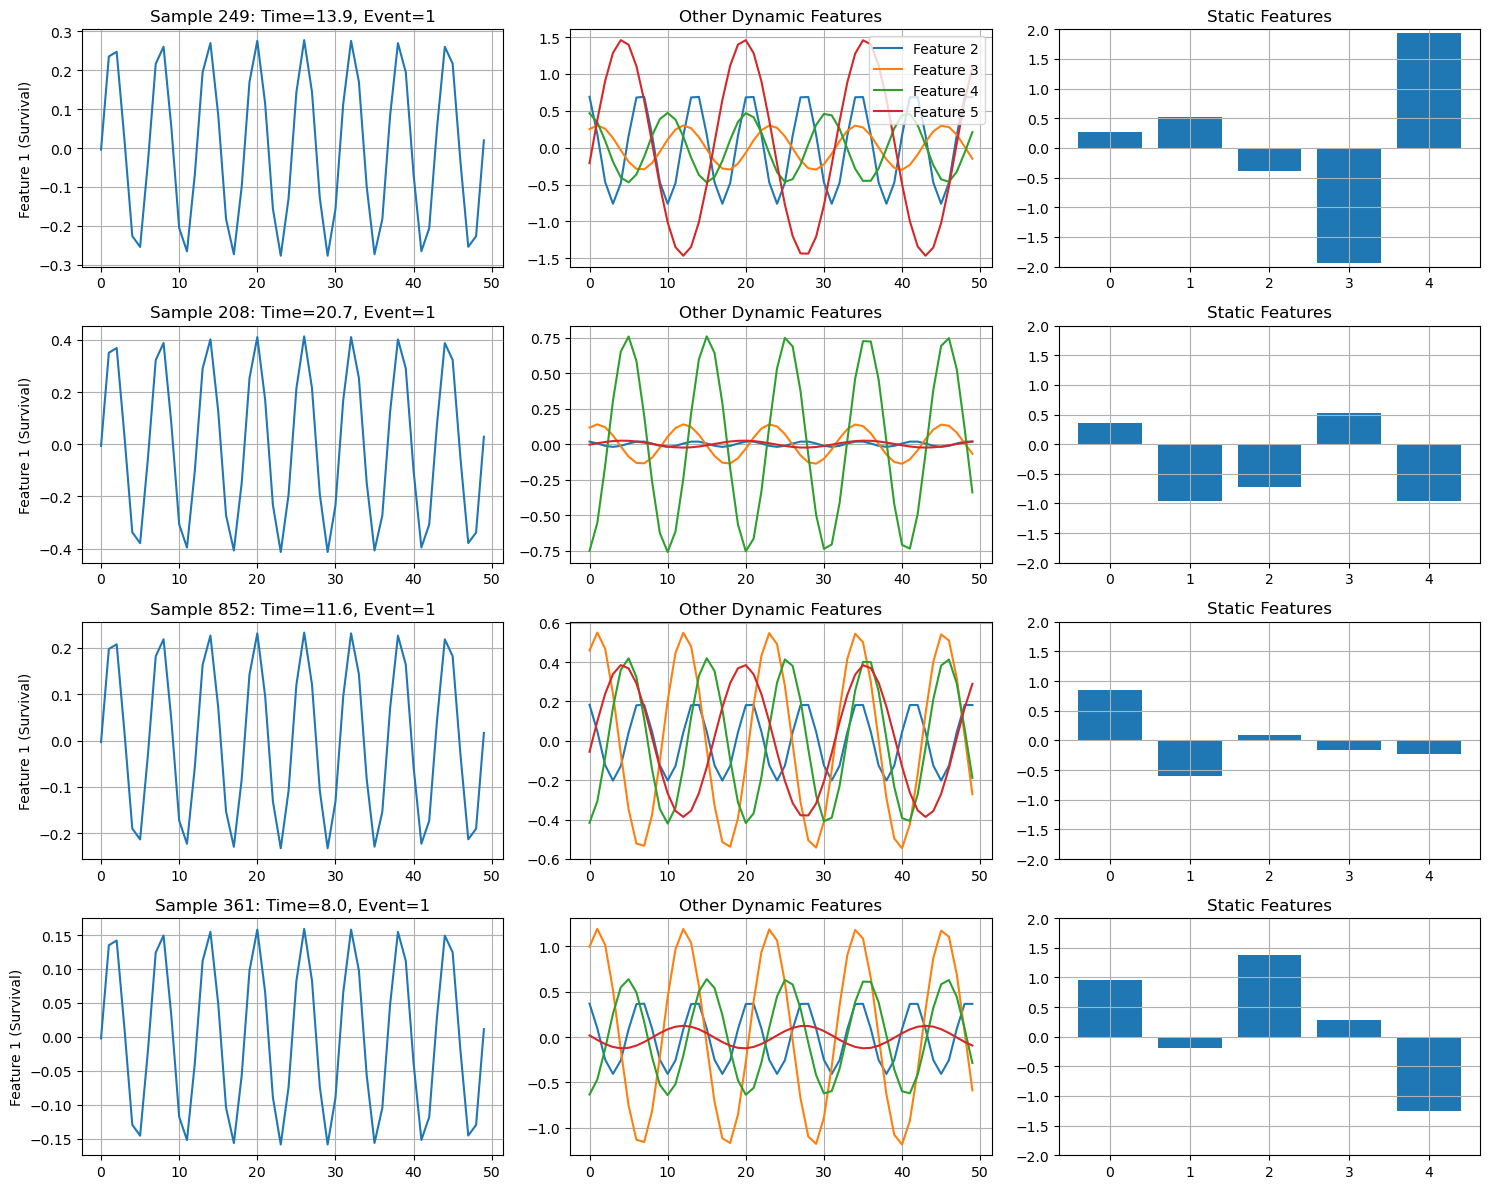

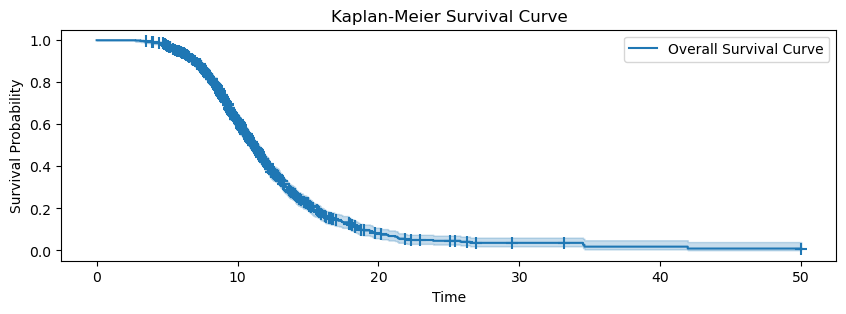

In [39]:
# Example usage
dataset = SurvivalSineWaveDataset(
    n_samples=1000,
    n_features=5,
    sequence_length=50,
    shape=5,
    scale=10.0,
    censoring=0.3,
    noise_level=0.0
)

print(dataset)

# Plot examples
fig = plot_survival_features(dataset)
plt.show()

# Plot KM curve for the dataset
survival_df = pd.DataFrame({
    'observed_time': dataset.observed_times.numpy(),
    'event_observed': dataset.events.numpy()
})
plot_KM(survival_df)

In [18]:
dataset.data
dataset.static_features


tensor([[ 0.4967, -0.1383,  0.6477,  1.5230, -0.2342],
        [-0.2341,  1.5792,  0.7674, -0.4695,  0.5426],
        [-0.4634, -0.4657,  0.2420, -1.9133, -1.7249],
        ...,
        [ 1.6358, -0.2210,  0.0694,  0.1926,  2.3921],
        [-2.0994,  0.6832, -0.1148,  0.5668, -0.6574],
        [-0.0490,  0.7114,  3.1129,  0.8080, -0.8481]])

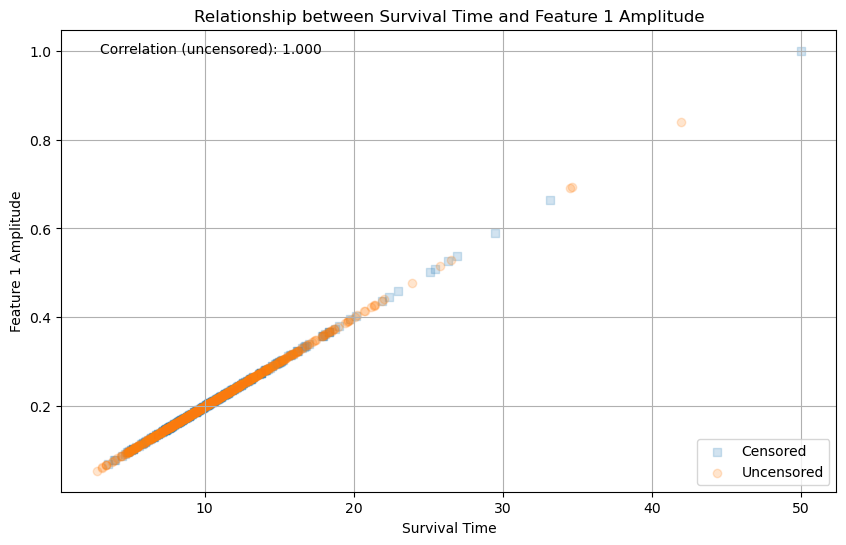

In [40]:
# Plot relationship between survival time and first feature amplitude
def plot_amplitude_survival_relationship(dataset):
    """Plot scatter of survival times vs amplitude of first feature"""
    
    # Get amplitude of first feature for each sample (max absolute value)
    amplitudes = dataset.data[:, 0].abs().max(dim=1)[0]
    
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot censored and uncensored separately
    censored = dataset.events == 0
    uncensored = dataset.events == 1
    
    plt.scatter(dataset.observed_times[censored], amplitudes[censored], 
                alpha=0.2, label='Censored', marker='s')
    plt.scatter(dataset.observed_times[uncensored], amplitudes[uncensored], 
                alpha=0.2, label='Uncensored', marker='o')
    
    plt.xlabel('Survival Time')
    plt.ylabel('Feature 1 Amplitude')
    plt.title('Relationship between Survival Time and Feature 1 Amplitude')
    plt.grid(True)
    plt.legend()
    
    # Add correlation coefficient for uncensored samples
    corr = np.corrcoef(dataset.observed_times[uncensored].numpy(), 
                       amplitudes[uncensored].numpy())[0,1]
    plt.text(0.05, 0.95, f'Correlation (uncensored): {corr:.3f}', 
             transform=plt.gca().transAxes)
    
    plt.show()

# Create the plot
plot_amplitude_survival_relationship(dataset)

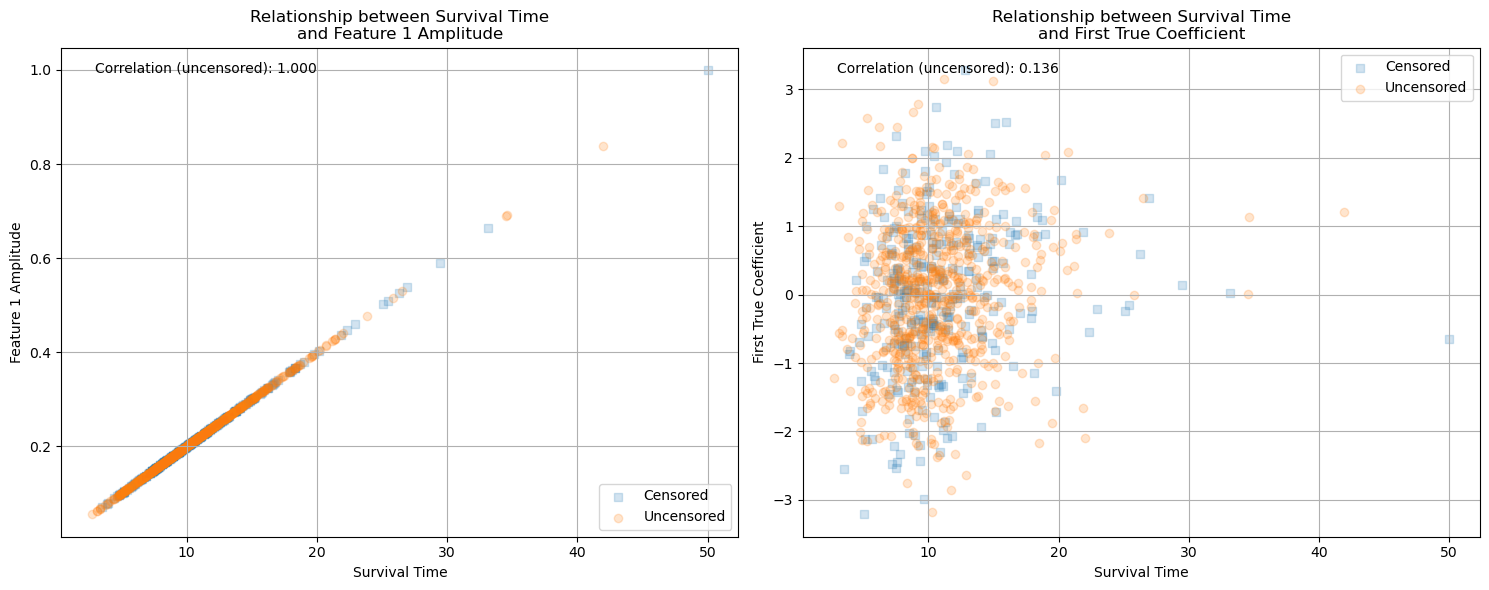

In [41]:
# Plot relationship between survival time and first feature amplitude
def plot_amplitude_survival_relationship(dataset):
    """Plot scatter of survival times vs amplitude of first feature and true coefficients"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # First subplot - Amplitude relationship
    # Get amplitude of first feature for each sample (max absolute value)
    amplitudes = dataset.data[:, 0].abs().max(dim=1)[0]
    
    # Plot censored and uncensored separately
    censored = dataset.events == 0
    uncensored = dataset.events == 1
    
    ax1.scatter(dataset.observed_times[censored], amplitudes[censored], 
                alpha=0.2, label='Censored', marker='s')
    ax1.scatter(dataset.observed_times[uncensored], amplitudes[uncensored], 
                alpha=0.2, label='Uncensored', marker='o')
    
    ax1.set_xlabel('Survival Time')
    ax1.set_ylabel('Feature 1 Amplitude')
    ax1.set_title('Relationship between Survival Time\nand Feature 1 Amplitude')
    ax1.grid(True)
    ax1.legend()
    
    # Add correlation coefficient for uncensored samples
    corr = np.corrcoef(dataset.observed_times[uncensored].numpy(), 
                       amplitudes[uncensored].numpy())[0,1]
    ax1.text(0.05, 0.95, f'Correlation (uncensored): {corr:.3f}', 
             transform=ax1.transAxes)
    
    # Second subplot - True coefficients relationship
    first_coef = dataset.static_features[:, 0]  # Get first static feature
    
    ax2.scatter(dataset.observed_times[censored], first_coef[censored], 
                alpha=0.2, label='Censored', marker='s')
    ax2.scatter(dataset.observed_times[uncensored], first_coef[uncensored], 
                alpha=0.2, label='Uncensored', marker='o')
    
    ax2.set_xlabel('Survival Time')
    ax2.set_ylabel('First True Coefficient')
    ax2.set_title('Relationship between Survival Time\nand First True Coefficient')
    ax2.grid(True)
    ax2.legend()
    
    # Add correlation coefficient for uncensored samples
    corr = np.corrcoef(dataset.observed_times[uncensored].numpy(), 
                       first_coef[uncensored].numpy())[0,1]
    ax2.text(0.05, 0.95, f'Correlation (uncensored): {corr:.3f}', 
             transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.show()

# Create the plot
plot_amplitude_survival_relationship(dataset)